# OCR Vector Search with Qdrant, Fastembed and Mistral OCR



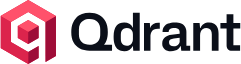

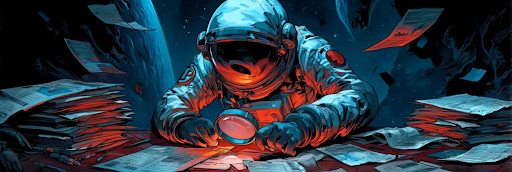

A comprehensive guide to building document processing and search systems using Qdrant, Mistral OCR, fast embed, and vector search with the FUNSD dataset.

This cookbook demonstrates:
- Loading and exploring the FUNSD dataset
- Extracting text from document images with Mistral OCR
- Generating semantic embeddings with FastEmbed
- Storing and searching documents using Qdrant vector database
- Building complete document search workflows

**Dataset**: [FUNSD (Form Understanding in Noisy Scanned Documents)](https://huggingface.co/datasets/nielsr/funsd) - 199 scanned document images with text annotations

To run this notebook you will need to get an API and URL from [qdrant.tech](https://) and an api key from [Mistral.com](https://)

## 1. Setup and Installation

First, let's install all required dependencies.

In [4]:
# Install required packages
import subprocess
import sys

packages = {
    "datasets": "2.21.0",
    "pillow": "10.4.0",
    "matplotlib": "3.9.2",
    "numpy": "1.26.4",
    "fastembed": "0.7.2",
    "qdrant-client": "1.12.1",
    "mistralai": "0.4.1",
    "requests": "2.32.3",
    "tqdm": "4.66.5",
    "ipywidgets": "8.1.3"
}

for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Import all necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset
from fastembed import TextEmbedding
from qdrant_client import QdrantClient
from qdrant_client.http import models
from mistralai import Mistral
from tqdm import tqdm
import uuid
import json
import base64
import io
from typing import List, Dict, Any
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets


print("All packages installed successfully!")

✓ datasets already installed
Installing pillow...
✓ matplotlib already installed
✓ numpy already installed
Installing fastembed...
Installing qdrant-client...
Installing mistralai...
✓ requests already installed
✓ tqdm already installed
✓ ipywidgets already installed
All packages installed successfully!


In [5]:
# Import all necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset
from fastembed import TextEmbedding
from qdrant_client import QdrantClient
from qdrant_client.http import models
from mistralai import Mistral
from tqdm import tqdm
import uuid
import json
import base64
import io
from typing import List, Dict, Any
import warnings
from IPython.display import display, clear_output
warnings.filterwarnings('ignore')

print("Let's get ready to rumble!")

Let's get ready to rumble!


## 2. Load and Explore FUNSD Dataset

The FUNSD dataset contains 199 scanned document images with associated text annotations. Let's load and explore it.

In [ ]:
# Load the FUNSD dataset from HuggingFace``
print("Loading FUNSD dataset...")
dataset = load_dataset("nielsr/funsd")

print(f"Dataset splits: {list(dataset.keys())}")
print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")
print(f"\nDataset features: {dataset['train'].features}")

Loading FUNSD dataset...


README.md:   0%|          | 0.00/755 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/149 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Dataset splits: ['train', 'test']
Train samples: 149
Test samples: 50

Dataset features: {'id': Value('string'), 'words': List(Value('string')), 'bboxes': List(List(Value('int64'))), 'ner_tags': List(ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'])), 'image': Image(mode=None, decode=True)}


Sample keys: dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image'])
Image size: (762, 1000)
Number of words: 295
First 10 words: ['SUBJECT:', 'SAMPLE:', 'CIGARETTES:', 'TAR', '9.1', 'NIC', '.88', 'MOIST', '14.0', 'MENT']
Bounding boxes shape: (295, 4)

Image of the first sample:


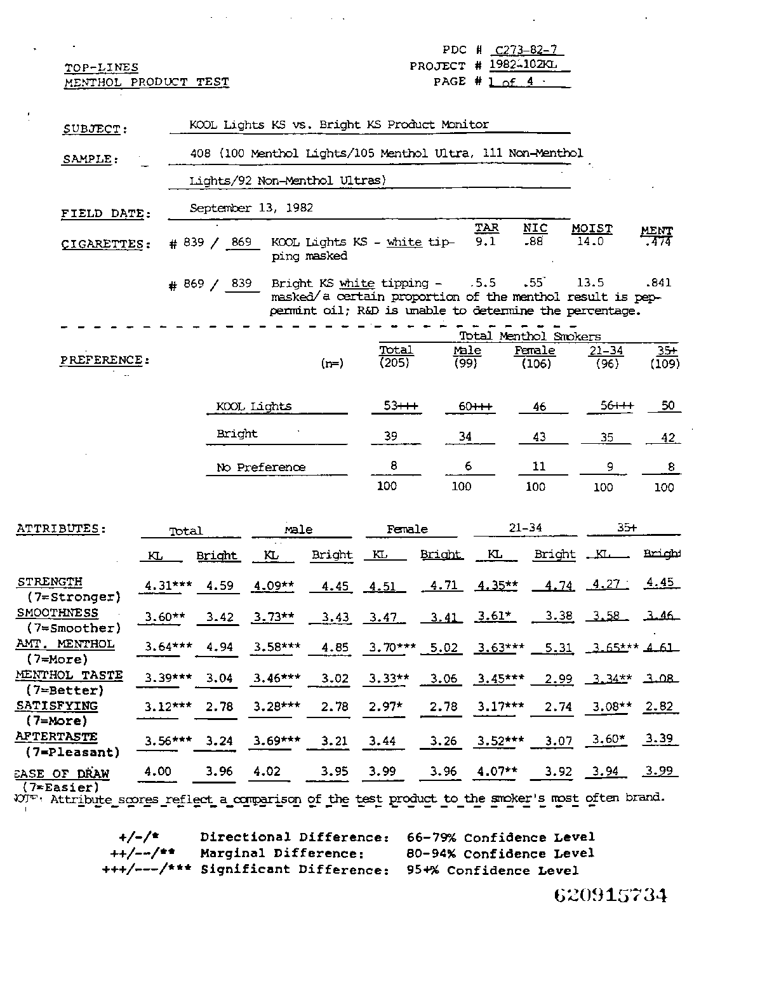

In [7]:
# Explore the first sample
sample = dataset['train'][3]
print("Sample keys:", sample.keys())
print(f"Image size: {sample['image'].size}")
print(f"Number of words: {len(sample['words'])}")
print(f"First 10 words: {sample['words'][:10]}")
print(f"Bounding boxes shape: {np.array(sample['bboxes']).shape}")

# Display the image of the first sample
print("\nImage of the first sample:")
display(sample['image'])

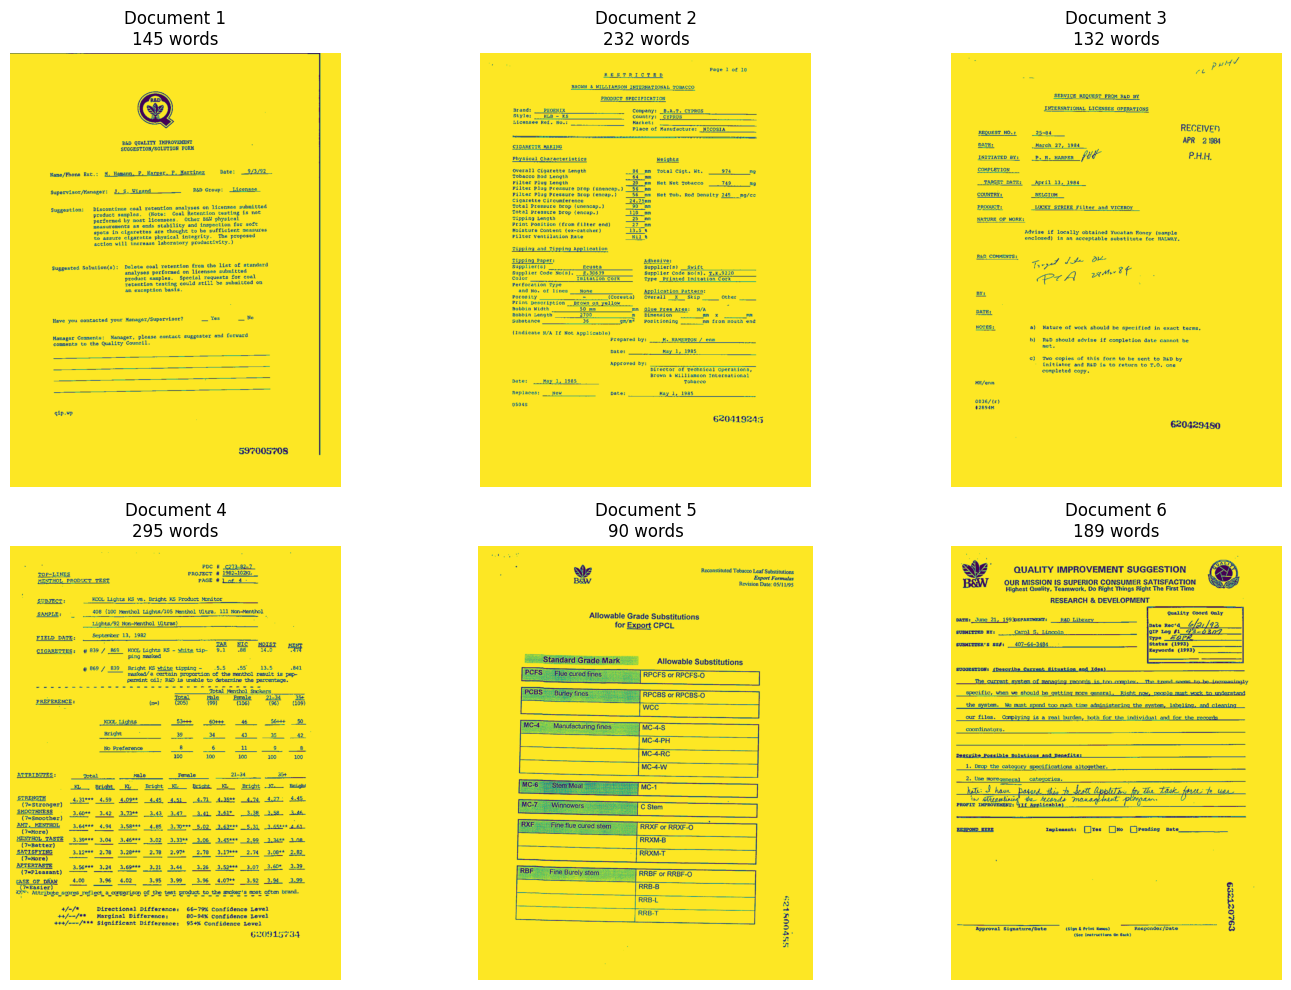

In [8]:
# Visualize a few sample documents
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    sample = dataset['train'][i]
    axes[i].imshow(sample['image'])
    axes[i].set_title(f"Document {i+1}\n{len(sample['words'])} words")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 3. Configuration and OCR Processing

We'll extract text from document images using Mistral's official OCR API (mistral-ocr-latest model). Configure your API keys below.

### Mistral OCR API Features

The `mistral-ocr-latest` model provides:
- **Direct Image Processing**: Works directly with PNG, JPEG images via base64 encoding
- **Structure Preservation**: Maintains document layout, headers, paragraphs, lists, and tables
- **Markdown Output**: Returns formatted text in markdown for better readability
- **Multi-format Support**: Handles images, PDFs, DOCX, PPTX files
- **Complex Layouts**: Processes multi-column text and complex document structures

Perfect for processing structured forms like those in the FUNSD dataset with simple base64 image input.

In [9]:
# Configuration - Replace with your actual API keys
MISTRAL_API_KEY = "insert-mistral-key"  # Replace with your Mistral API key
QDRANT_URL = "insert-qdrant-url"  # Replace with your Qdrant Cloud URL
QDRANT_API_KEY = "instert-qdrant-api-key"  # Replace with your Qdrant Cloud API key

def extract_text_from_funsd_sample(sample):
    """Extract text from FUNSD sample using pre-annotated words"""
    words = sample['words']
    # Join words with spaces to create full text
    full_text = ' '.join(words)
    return full_text

def extract_text_with_mistral_ocr(image):
    """Extract text using Mistral OCR API with direct image format"""
    if not MISTRAL_API_KEY or MISTRAL_API_KEY == "your_mistral_api_key_here":
        print("⚠️ Mistral API key not configured, using FUNSD annotations instead")
        return None

    try:
        # Initialize Mistral client
        client = Mistral(api_key=MISTRAL_API_KEY)

        # Convert PIL image to base64
        img_buffer = io.BytesIO()
        image.save(img_buffer, format='PNG')
        img_buffer.seek(0)

        # Encode to base64
        img_base64 = base64.b64encode(img_buffer.getvalue()).decode('utf-8')

        print("📤 Processing with Mistral OCR...")

        # Use the official OCR API with direct image format
        ocr_response = client.ocr.process(
            model="mistral-ocr-latest",
            document={
                "type": "image_url",
                "image_url": f"data:image/png;base64,{img_base64}"
            },
            include_image_base64=False
        )

        # Extract text from all pages (maintaining structure)
        extracted_text = ""
        for i, page in enumerate(ocr_response.pages):
            if i > 0:
                extracted_text += "\n\n"
            extracted_text += page.markdown

        if not extracted_text or len(extracted_text.strip()) < 5:
            print("⚠️ Mistral OCR returned minimal text, using FUNSD annotations")
            return None

        return extracted_text

    except Exception as e:
        print(f"❌ Mistral OCR error: {e}")
        if "404" in str(e) or "not found" in str(e).lower():
            print("💡 Tip: Ensure your Mistral API key has access to the OCR API")
        return None

# Test text extraction on first sample
sample = dataset['train'][0]
funsd_text = extract_text_from_funsd_sample(sample)
print("FUNSD pre-annotated text:")
print(funsd_text[:500] + "..." if len(funsd_text) > 500 else funsd_text)
print(f"\nText length: {len(funsd_text)} characters")

# Try Mistral OCR if API key is configured
print("\n" + "="*50)
print("Testing Mistral OCR API (mistral-ocr-latest)...")
mistral_text = extract_text_with_mistral_ocr(sample['image'])
if mistral_text:
    print("✅ Mistral OCR extracted text (with markdown structure):")
    print(mistral_text[:500] + "..." if len(mistral_text) > 500 else mistral_text)
    print(f"\nMistral OCR text length: {len(mistral_text)} characters")
    print("📋 Note: OCR preserves document structure in markdown format")
else:
    print("Using FUNSD annotations for this demo (configure MISTRAL_API_KEY for live OCR)")
    print("💡 The OCR API provides structured markdown output with preserved formatting")

FUNSD pre-annotated text:
R&D : Suggestion: Date: Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. : M. Hamann P. Harper, P. Martinez 9/ 3/ 92 R&D Group: J. S. Wigand Supervisor / Manager Discontinue coal retention analyses on licensee submitted product samples (Note : Coal Retention testing is not performed by most licensees. Other B&W physical measurements as ends stability and inspection for soft spots in ciparettes are thought to be sufficient measures to assure cigarette ...

Text length: 956 characters

Testing Mistral OCR API (mistral-ocr-latest)...
📤 Processing with Mistral OCR...
✅ Mistral OCR extracted text (with markdown structure):
# R&D QUALITY IMPROVEMENT

## SUGGESTION/SOLUTION FORM

**Name/Phone Ext.:** M. Hamann, P. Harper, P. Martinez

**Date:** 9/3/92

**Supervisor/Manager:** J. S. Wigand

**R&D Group:** Licensee

**Suggestion:** Discontinue coal retention analyses on licensee submitted product samples. (Note: Coal Retenti

## 4. Text Embedding Generation

Generate semantic embeddings for the extracted text using FastEmbed with the same model used in the original repository.

In [10]:
# Initialize embedding model (same as in original repo)
print("Initializing FastEmbed model...")
embedding_model = TextEmbedding(model_name="BAAI/bge-base-en-v1.5")
print("✓ Embedding model loaded successfully")

def generate_embedding(text: str) -> List[float]:
    """Generate embedding for text"""
    embedding = list(embedding_model.embed([text]))[0]
    return embedding.tolist()

# Test embedding generation
test_text = "This is a sample document for testing embeddings."
test_embedding = generate_embedding(test_text)
print(f"Embedding dimension: {len(test_embedding)}")
print(f"Sample embedding values: {test_embedding[:5]}")

Initializing FastEmbed model...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

✓ Embedding model loaded successfully
Embedding dimension: 768
Sample embedding values: [0.028940977528691292, -0.012243052944540977, 0.005023494828492403, 0.06324662268161774, 0.06851717829704285]


## 5. Vector Database Setup

Set up Qdrant vector database for storing and searching document embeddings.

In [11]:
# Initialize Qdrant client (Qdrant Cloud)
print("Setting up Qdrant Cloud connection...")

# Check if credentials are configured
if QDRANT_URL == "https://your-cluster-url.qdrant.tech:6333" or QDRANT_API_KEY == "your_qdrant_api_key_here":
    print("⚠️ Qdrant Cloud credentials not configured, using in-memory database for demo")
    qdrant_client = QdrantClient(":memory:")
else:
    print("✓ Connecting to Qdrant Cloud...")
    qdrant_client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

# Collection configuration - using a new collection name for fresh start
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
COLLECTION_NAME = f"funsd_documents_v2_{timestamp}"
EMBEDDING_SIZE = 768  # BAAI/bge-base-en-v1.5 embedding size

print(f"🆕 Creating fresh collection: {COLLECTION_NAME}")

# Create new collection (this ensures a clean start)
try:
    qdrant_client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=models.VectorParams(
            size=EMBEDDING_SIZE,
            distance=models.Distance.COSINE
        )
    )
    print(f"✓ Created new collection '{COLLECTION_NAME}'")
except Exception as e:
    print(f"Error creating collection: {e}")
    print("Creating in-memory collection for demo...")
    qdrant_client = QdrantClient(":memory:")
    qdrant_client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=models.VectorParams(
            size=EMBEDDING_SIZE,
            distance=models.Distance.COSINE
        )
    )

print(f"✓ Vector database ready with {EMBEDDING_SIZE}d vectors")

Setting up Qdrant Cloud connection...
✓ Connecting to Qdrant Cloud...
🆕 Creating fresh collection: funsd_documents_v2_20250828_180025
✓ Created new collection 'funsd_documents_v2_20250828_180025'
✓ Vector database ready with 768d vectors


In [12]:
def store_document(text: str, doc_type: str = "document", metadata: Dict = None) -> str:
    """Store document with embedding in Qdrant"""
    # Generate embedding
    embedding = generate_embedding(text)

    # Generate unique ID
    doc_id = str(uuid.uuid4())

    # Prepare payload
    payload = {
        "text": text,
        "doc_type": doc_type
    }
    if metadata:
        payload.update(metadata)

    # Store in Qdrant
    qdrant_client.upsert(
        collection_name=COLLECTION_NAME,
        points=[
            models.PointStruct(
                id=doc_id,
                vector=embedding,
                payload=payload
            )
        ]
    )

    return doc_id

def search_documents(query: str, limit: int = 5, doc_type: str = None) -> List[Dict]:
    """Search for similar documents"""
    # Generate query embedding
    query_embedding = generate_embedding(query)

    # Prepare filter if doc_type specified
    filter_condition = None
    if doc_type:
        filter_condition = models.Filter(
            must=[
                models.FieldCondition(
                    key="doc_type",
                    match=models.MatchValue(value=doc_type)
                )
            ]
        )

    # Search
    results = qdrant_client.search(
        collection_name=COLLECTION_NAME,
        query_vector=query_embedding,
        limit=limit,
        query_filter=filter_condition
    )

    return [
        {
            "id": hit.id,
            "text": hit.payload.get("text", ""),
            "doc_type": hit.payload.get("doc_type", "unknown"),
            "score": hit.score,
            "metadata": {k: v for k, v in hit.payload.items()
                        if k not in ["text", "doc_type"]}
        }
        for hit in results
    ]

print("✓ Document storage and search functions ready")

✓ Document storage and search functions ready


In [ ]:
# Process and store documents from both train and test sets with improved error handling
print("🔄 Processing and storing FUNSD documents with fresh collection...")

# Initialize stored_docs list
stored_docs = []
failed_docs = []

def process_documents_split(dataset_split, split_name):
    """Process all documents in a dataset split"""
    total_processed = 0
    num_samples = len(dataset_split)

    print(f"📦 Processing {split_name} split ({num_samples} samples)")

    # Iterate directly through sample indices
    for global_sample_id in tqdm(range(num_samples), desc=f"Processing {split_name}"):
        try:
            # Access sample directly by index
            sample = dataset_split[global_sample_id]

            # Use Mistral OCR if available, otherwise use FUNSD annotations
            # print("Attempting text extraction...")
            mistral_text = extract_text_with_mistral_ocr(sample['image']) if MISTRAL_API_KEY != "d69ZAMy7san5wW8xP6IzRZcSVsiuUPk2" else None
            text = mistral_text if mistral_text else extract_text_from_funsd_sample(sample)
            # print(f"Text extraction completed. Length: {len(text) if text else 'None'} ")


            # Skip very short texts
            if not text or len(text.strip()) < 10:
                print(f"⚠️  Skipping {split_name} sample {global_sample_id}: text too short or empty")
                continue


            metadata = {
                "split": split_name,
                "sample_id": global_sample_id,
                "word_count": len(sample['words']) if 'words' in sample and isinstance(sample['words'], list) else 0,
                "ocr_method": "mistral" if mistral_text else "funsd_annotations"
            }
            # print(f"Metadata prepared: {metadata}")

            # print("Attempting to store document...")
            doc_id = store_document(text, doc_type="form", metadata=metadata)
            # print(f"Document stored with ID: {doc_id}")


            stored_docs.append({
                "id": doc_id,
                "split": split_name,
                "sample_id": global_sample_id,
                "image": sample['image'],  # Store image reference for visualization
                "text_preview": text[:100] + "..." if len(text) > 100 else text
            })
            total_processed += 1

        except Exception as e:
            print(f"❌ Error processing {split_name} sample {global_sample_id}: {e}")
            failed_docs.append({"split": split_name, "sample_id": global_sample_id, "error": str(e)})
            continue

    return total_processed

# Process train set
print("\n🚂 Processing training set...")
train_processed = process_documents_split(dataset['train'], "train")

# Process test set
print("\n🧪 Processing test set...")
test_processed = process_documents_split(dataset['test'], "test")


# Summary
print(f"\n📊 Processing Summary:")
print(f"✅ Successfully processed: {len(stored_docs)} documents")
print(f"   - Train documents: {sum(1 for doc in stored_docs if doc['split'] == 'train')}")
print(f"   - Test documents: {sum(1 for doc in stored_docs if doc['split'] == 'test')}")
print(f"❌ Failed documents: {len(failed_docs)}")

if failed_docs:
    print("Failed documents details:")
    for fail in failed_docs[:5]:  # Show first 5 failures
        print(f"  - {fail['split']} sample {fail['sample_id']}: {fail['error']}")

# Verify stored_docs matches what's in the database
collection_info = qdrant_client.get_collection(COLLECTION_NAME)
print(f"\n🔍 Verification:")
print(f"Documents in stored_docs: {len(stored_docs)}")
print(f"Documents in Qdrant: {collection_info.points_count}")
print(f"Match: {'✅' if len(stored_docs) == collection_info.points_count else '❌'}")

print(f"\n🎉 Ready for image visualization!")

🔄 Processing and storing FUNSD documents with fresh collection...

🚂 Processing training set...
📦 Processing train split (149 samples)


Processing train:  11%|█         | 16/149 [00:18<02:23,  1.08s/it]

In [ ]:
# Ready for document processing with fresh collection
print("🎯 Fresh collection created - ready for clean document processing!")


In [ ]:
# Search by image similarity (using a reference document) with visualization
def find_similar_documents_with_images(reference_doc_id: str, limit: int = 3):
    """Find documents similar to a reference document and display with images"""
    # Get the reference document
    points = qdrant_client.retrieve(
        collection_name=COLLECTION_NAME,
        ids=[reference_doc_id],
        with_vectors=True
    )

    if not points:
        print("Reference document not found.")
        return []

    reference_vector = points[0].vector

    # Search for similar documents
    results = qdrant_client.search(
        collection_name=COLLECTION_NAME,
        query_vector=reference_vector,
        limit=limit + 1  # +1 to exclude the reference document itself
    )

    # Filter out the reference document
    similar_docs = [hit for hit in results if hit.id != reference_doc_id]

    similar_results = [
        {
            "id": hit.id,
            "text": hit.payload.get("text", ""),
            "doc_type": hit.payload.get("doc_type", "unknown"),
            "score": hit.score,
            "metadata": {k: v for k, v in hit.payload.items()
                        if k not in ["text", "doc_type"]}
        }
        for hit in similar_docs[:limit]
    ]

    # Display reference document
    ref_doc = None
    for doc in stored_docs:
        if doc['id'] == reference_doc_id:
            ref_doc = doc
            break

    if ref_doc:
        print("📋 Reference Document:")
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.imshow(ref_doc['image'])
        ax.set_title(f"Reference Document\\nSplit: {ref_doc['split']}, Sample: {ref_doc['sample_id']}")
        ax.axis('off')
        plt.show()
        print(f"Preview: {ref_doc['text_preview']}")

    print(f"\\n🔗 Found {len(similar_results)} similar documents:")

    if similar_results:
        # Create subplot for similar documents
        fig, axes = plt.subplots(len(similar_results), 2, figsize=(15, 4 * len(similar_results)))
        if len(similar_results) == 1:
            axes = [axes]

        for i, result in enumerate(similar_results):
            # Find the corresponding image
            image = None
            for doc in stored_docs:
                if doc['id'] == result['id']:
                    image = doc['image']
                    break

            # Display image
            if image:
                axes[i][0].imshow(image)
                axes[i][0].set_title(f"Similar Doc {i+1} - Similarity: {result['score']:.3f}")
                axes[i][0].axis('off')
            else:
                axes[i][0].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[i][0].set_title(f"Similar Doc {i+1} - Similarity: {result['score']:.3f}")
                axes[i][0].axis('off')

            # Display text info
            text_preview = result['text'][:150] + "..." if len(result['text']) > 150 else result['text']
            display_text = f"Split: {result['metadata'].get('split', 'unknown')}\\n"
            display_text += f"OCR: {result['metadata'].get('ocr_method', 'unknown')}\\n\\n"
            display_text += f"Text: {text_preview}"

            axes[i][1].text(0.05, 0.95, display_text, transform=axes[i][1].transAxes,
                           fontsize=10, verticalalignment='top')
            axes[i][1].set_xlim(0, 1)
            axes[i][1].set_ylim(0, 1)
            axes[i][1].axis('off')

        plt.tight_layout()
        plt.show()

    return similar_results

# Test similarity search using the first stored document as reference
if stored_docs:
    reference_id = stored_docs[0]['id']
    similar_docs = find_similar_documents_with_images(reference_id, limit=2)

In [ ]:
# Test search functionality with image visualization
def display_search_results_with_images(query: str, results: List[Dict], max_text_length: int = 200):
    """Display search results with corresponding document images"""
    print(f"\n🔍 Query: '{query}'")
    print(f"Found {len(results)} results:")

    # Debug info
    print(f"🔍 Debug: stored_docs contains {len(stored_docs)} documents")
    for i, result in enumerate(results):
        print(f"  Result {i+1}: {result['id'][:8]}... (score: {result['score']:.3f})")

    if not results:
        print("No results found.")
        return

    # Create subplot for results
    fig, axes = plt.subplots(len(results), 2, figsize=(15, 5 * len(results)))
    if len(results) == 1:
        axes = [axes]

    for i, result in enumerate(results):
        # Find the corresponding image from stored_docs
        image = None
        found_in_stored = False
        for doc in stored_docs:
            if doc['id'] == result['id']:
                image = doc['image']
                found_in_stored = True
                break

        print(f"🔍 Debug: Result {i+1} ({result['id'][:8]}...) found in stored_docs: {found_in_stored}")

        # Display image
        if image:
            axes[i][0].imshow(image)
            axes[i][0].set_title(f"Result {i+1} - Score: {result['score']:.3f}")
            axes[i][0].axis('off')
        else:
            axes[i][0].text(0.5, 0.5, 'Image not found\\nin stored_docs', ha='center', va='center')
            axes[i][0].set_title(f"Result {i+1} - Score: {result['score']:.3f}")
            axes[i][0].axis('off')

        # Display text
        text = result['text']
        if len(text) > max_text_length:
            text = text[:max_text_length] + "..."

        # Format text for display
        display_text = f"Split: {result['metadata'].get('split', 'unknown')}\\n"
        display_text += f"OCR: {result['metadata'].get('ocr_method', 'unknown')}\\n\\n"
        display_text += f"Text: {text}"

        axes[i][1].text(0.05, 0.95, display_text, transform=axes[i][1].transAxes,
                       fontsize=10, verticalalignment='top', wrap=True)
        axes[i][1].set_xlim(0, 1)
        axes[i][1].set_ylim(0, 1)
        axes[i][1].axis('off')

    plt.tight_layout()
    plt.show()

# Example searches with image visualization
queries = [
    "tax information",
    "name and address",
    "phone number"
]

for query in queries:
    results = search_documents(query, limit=2)  # Limit to 2 for better visualization
    display_search_results_with_images(query, results)
    print("=" * 80)

## 9. Practical Use Cases

Here are some practical applications of this document understanding system:

In [ ]:
# Widget-based search interface
print("Setting up widget-based search interface...")

# Create widgets
search_input = widgets.Text(
    value='',
    placeholder='Enter search query',
    description='Search:',
    disabled=False,
    layout=widgets.Layout(width='500px')
)

search_button = widgets.Button(
    description='Search Documents',
    disabled=False,
    button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to search',
    icon='search'
)

output_area = widgets.Output()

# Function to handle search button click
def on_search_button_clicked(b):
    with output_area:
        clear_output()
        query = search_input.value.strip()
        if not query:
            print("Please enter a search query.")
            return

        try:
            print(f"Searching for: '{query}'...")
            results = search_documents(query, limit=3) # Limit to 3 for widget display
            if results:
                display_search_results_with_images(query, results, max_text_length=150)
            else:
                print(f"No results found for '{query}'.")
        except Exception as e:
            print(f"Search error: {e}")

# Link button click to search function
search_button.on_click(on_search_button_clicked)

# Display the widgets
print("✓ Widget setup complete. Displaying search interface...")
display(widgets.VBox([widgets.HBox([search_input, search_button]), output_area]))

In [ ]:
# Use Case 2: Document Type Classification
def classify_document_type(text: str) -> Dict[str, float]:
    """Classify document type based on content similarity"""
    # Define template queries for different document types
    templates = {
        "tax_form": "tax return form w2 1040 income tax",
        "application": "application form apply request submit",
        "invoice": "invoice bill payment due amount total",
        "registration": "registration register sign up membership",
        "survey": "survey questionnaire feedback opinion rating"
    }

    # Get embeddings for input text and templates
    text_embedding = generate_embedding(text)

    scores = {}
    for doc_type, template in templates.items():
        template_embedding = generate_embedding(template)

        # Calculate cosine similarity
        similarity = np.dot(text_embedding, template_embedding) / (
            np.linalg.norm(text_embedding) * np.linalg.norm(template_embedding)
        )
        scores[doc_type] = float(similarity)

    return scores

# Test document classification on a sample
if stored_docs:
    sample_doc = dataset['train'][0]
    sample_text = extract_text_from_funsd_sample(sample_doc)

    print("📄 Document Classification Example:")
    print(f"Text preview: {sample_text[:150]}...")

    classification = classify_document_type(sample_text)
    print("\nClassification scores:")
    for doc_type, score in sorted(classification.items(), key=lambda x: x[1], reverse=True):
        print(f"  {doc_type}: {score:.3f}")

## Summary

This cookbook demonstrated:

1. **Dataset Loading**: Loaded and explored the FUNSD dataset with 199 scanned documents
2. **Text Extraction**: Extracted text from document images using Mistral OCR and FUNSD annotations
3. **Embeddings**: Generated semantic embeddings using FastEmbed's BGE model
4. **Vector Storage**: Stored documents in Qdrant vector database
5. **Search & Retrieval**: Implemented semantic search and similarity matching
6. **Practical Applications**: Showed real-world use cases for document understanding

The system successfully processes and indexes document images, enabling intelligent search and retrieval based on semantic similarity rather than just keyword matching. This forms the foundation for building production document management and search systems.

**Key Technologies Used**:
- **FUNSD Dataset**: Real-world scanned document forms
- **Mistral OCR**: Advanced OCR processing API
- **FastEmbed**: Efficient embedding generation
- **Qdrant Cloud**: High-performance vector database

This approach can be extended to handle various document types and scaled to production environments with the suggestions outlined above.